# Neural network - Simple + some optimization  

<b>Optimize 1.</b> Change cost function to cross-entropy  
<b>Optimize 2.</b> Add L2 regularization  
<b>Optimize 3.</b> Add weight initialization  

# How to choose hyper-parameters  (Manually)
## Broad strategy: 
Note that, we use validation data to judge the performance of the network
1. Strip down the problem to some easier problem to make the network runs faster  
2. Individually adjust each hyper-param to gradually improve performance  
3. Then experiment with a more complex architecture (more hidden layers, more neurons) and adjust other hyper-param again  

## Learning rate $\eta$:
1. Estimate the threshold value for η at which the cost on the training data immediately begins decreasing, instead of oscillating or increasing  
2. If the cost decreases during the first few epochs, then try increasing η
3. If the cost oscillates or increases during the first few epochs, then try decreasing η
### Learning rate schedule: 
We can apply the same strategy as early stopping here for learning rate. At the early stage of learning, we want to change  the weight quickly. Later, when the validation accuracy starts to get worse, we decrease the learning rate by some amount until some threshold, then we terminate


## Number of epochs:
This is pretty straighforward, we use early stopping. This also prevents us from overfitting.  
In short, if the accuracy of the validation data <b>doesn't improve in the last 10 epochs</b>, we stop the training. However, some network may difficult to improve the accuracy, so we use this strategy in experimentation, after we understand the network, we can tweak the value to get an appropriate result

## Regularization param $\lambda$:
<b>Note that we should tune the learning rate before we tune this parameter</b>  
The principle is the same, we choose an intial value, then increasing or decreasing until we get a good accuracy on the validation data

## Mini-batch size:
Since the mini-batch size is relatively independent of other hyper-parameters, we can just trial a number of different mini-batch size (other hyper-parameters should generate an acceptable validation accuracy). Plot the validation accuracy versus time and choose the size with an appropriate accuracy and time performance.

# Automated techniques for choosing hyper parameters
## Grid search ([paper](https://dl.acm.org/doi/10.5555/2188385.2188395))
## Bayesian approach ([paper](http://papers.nips.cc/paper/4522-practical-bayesian-optimization-of-machine-learning-algorithms.pdf))

In [1]:
import random
import numpy as np
import tensorflow as tf
import os

## Input data

In [2]:
# Load data
cwd = os.getcwd()
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data(
    path = cwd + '/mnist.npz'
)

In [3]:
# Normalize data
def vectorize(y):
    res = np.zeros((10, 1))
    res[y] = 1.0
    return res

x_train, x_test = x_train / 255.0, x_test / 255.0
x_eval, y_eval = x_train[-10000:], y_train[-10000:]
x_train, y_train = x_train[:-10000], y_train[:-10000]

x_train = [np.reshape(x, (784, 1)) for x in x_train]
y_train = [vectorize(y) for y in y_train]
data_train = list(zip(x_train, y_train))

x_eval = [np.reshape(x, (784, 1)) for x in x_eval]
data_eval = list(zip(x_eval, y_eval))

x_test = [np.reshape(x, (784, 1)) for x in x_test]
data_test = list(zip(x_test, y_test))

## Activation function

In [4]:
def sigmoid(z):
    """Sigmoid function"""
    return 1.0 / (1.0 + np.exp(-z))

def sigmoid_prime(z):
    """Derivative of sigmoid function"""
    return sigmoid(z) * (1 - sigmoid(z))

## Cost function

In [5]:
class QuadraticCost(object):
    @staticmethod
    def fn(a, y):
        """Return the cost between @a and @y"""
        return 0.5 * np.linalg.norm(a-y)**2

    @staticmethod
    def delta(z, a, y):
        """Return the error delta from the output layer"""
        return (a - y) * sigmoid_prime(z)
    
class CrossEntropyCost(object):
    @staticmethod
    def fn(a, y):
        """
        Return the cost between @a and @y
        nan_to_num in case a=0 => log(a)=nan
        """
        return np.sum(np.nan_to_num(-y*np.log(a)-(1-y)*np.log(1-a)))

    @staticmethod
    def delta(z, a, y):
        """Return the error delta from the output layer"""
        return (a - y)

## Network

In [14]:
class Network(object):
    def __init__(self, shape, cost = CrossEntropyCost):
        """
        @shape: shape of the network, ex: [3, 2, 1]
        @n: number of layers
        @B: list of biases
        @W: list of weights
        """
        self.n = len(shape)
        self.default_weight_init(shape)
        self.cost = cost
    
    def default_weight_init(self, shape):
        self.B = [np.random.randn(y, 1) for y in shape[1:]]
        self.W = [np.random.randn(y, x)/np.sqrt(x) 
                  for x, y in zip(shape[:-1], shape[1:])]
        
    def feedforward(self, a):
        """
        Return the output of the network if @a is input
        """
        for w, b in zip(self.W, self.B):
            a = sigmoid(np.dot(w, a) + b)
        
        return a
    
    def backprop(self, x, y):
        """
        Return a tuple (delta_W, delta_B) representing the gradient
        for the cost function C_x
        """
        delta_W = [np.zeros(w.shape) for w in self.W]
        delta_B = [np.zeros(b.shape) for b in self.B]
        
        # Feed forward
        a = x
        a_lst = [x]
        z_lst = []        
        for w, b in zip(self.W, self.B):
            z = np.dot(w, a) + b
            z_lst.append(z)
            a = sigmoid(z)
            a_lst.append(a)
         
        # Backward pass
        delta = self.cost.delta(z_lst[-1], a_lst[-1], y)
        delta_W[-1] = np.dot(delta, a_lst[-2].transpose())
        delta_B[-1] = delta
        
        for l in range(2, self.n):
            z = z_lst[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.W[-l+1].transpose(), delta) * sp
            delta_W[-l] = np.dot(delta, a_lst[-l-1].transpose())
            delta_B[-l] = delta            
    
        return (delta_W, delta_B)
    
    def update(self, batch, eta, lamda, n):
        """
        Update network's weights and biases:
            1. Loop through each (x, y) ~ 1 example in the batch:
                1.1. Do 1 backprop
                1.2. Accumulate @delta_W and @delta_B
            2. Apply the update to network weights and biases
        """
        delta_W_sum = [np.zeros(w.shape) for w in self.W]
        delta_B_sum = [np.zeros(b.shape) for b in self.B]
        
        for x, y in batch:
            delta_W, delta_B = self.backprop(x, y)
            delta_W_sum = [dw + dws for dw, dws in zip(delta_W, delta_W_sum)]
            delta_B_sum = [db + dbs for db, dbs in zip(delta_B, delta_B_sum)]

        # L2 regularization
        n_batch = len(batch)
        self.W = [(1 - eta * lamda / n) * w - eta * dws / n_batch
                 for w, dws in zip(self.W, delta_W_sum)]
        self.B = [b - eta * dbs / n_batch
                 for b, dbs in zip(self.B, delta_B_sum)]
        
    def SGD(self, data_train, epochs, batch_size, eta, 
            lamda = 0.0,
            data_eval = None,
            monitor_train_cost = False,
            monitor_train_accu = False,
            monitor_eval_cost = False,
            monitor_eval_accu = False,
            early_stopping_n = 0):
        """
        Stochastic gradient descent: 
            1. Loop through each epoch:
                1.1. Randomly shuffle the @data_train, 
                    then partitions it into batches. 
                1.2. Loop through each batch to apply a single
                    step of gradient descent to update the 
                    network weights and biases.
        """
        
        # Init
        n = len(data_train)
        if data_eval:
            n_eval = len(data_eval)
        
        train_cost, train_accu = [], []
        eval_cost, eval_accu = [], []
        
        # Early stopping
        best_accuracy = 1        
        
        for i in range(epochs):
            random.shuffle(data_train)
            batches = [
                data_train[k: k+batch_size]
                for k in range(0, n, batch_size)]
            
            for batch in batches:
                self.update(batch, eta, lamda, n)
            
            print(f"Epoch {i} completed")
            
            if monitor_train_cost:
                cost = self.total_cost(data_train, lamda)
                train_cost.append(cost)
                print(f"\tTrain cost: {cost}")
            if monitor_train_accu:
                accu = self.accuracy(data_train, convert = True)
                train_accu.append(accu)
                print(f"\tTrain accuracy: {accu}/{n}")
            if monitor_eval_cost:
                cost = self.total_cost(data_eval, lamda, convert = True)
                eval_cost.append(cost)
                print(f"\tEval cost: {cost}")
            if monitor_eval_accu:
                accu = self.accuracy(data_eval)
                eval_accu.append(accu)
                print(f"\tEval accuracy: {accu}/{n_eval}")
        
        return train_cost, train_accu, \
            eval_cost, eval_accu
            
                
    def total_cost(self, data, lamda, convert = False):
        cost = 0.0
        n = len(data)
        
        for x, y in data:
            a = self.feedforward(x)
            if convert:
                y = vectorize(y)
            cost += self.cost.fn(a, y) / n
        cost += 0.5 * lamda / n * sum(np.linalg.norm(w)**2 for w in self.W)
        
        return cost
                
     
    def accuracy(self, data, convert = False):
        if convert:
            res = [(np.argmax(self.feedforward(x)), np.argmax(y))
                  for (x, y) in data]
        else:
            res = [(np.argmax(self.feedforward(x)), y)
                   for (x, y) in data]
        return sum(int(x == y) for (x, y) in res)        

## Experiment

In [26]:
net = Network([784, 30, 10], cost = CrossEntropyCost)
train_cost, train_accu, eval_cost, eval_accu = net.SGD(
    data_train, 30, 10, .1,
    lamda = 5.0,
    data_eval = data_eval,
    monitor_train_cost = True,
    monitor_train_accu = True,
    monitor_eval_cost = True,
    monitor_eval_accu = True)

Epoch 0 completed
	Train cost: 0.5624240487073426
	Train accuracy: 46112/50000
	Eval cost: 0.6634508374047163
	Eval accuracy: 9262/10000
Epoch 1 completed
	Train cost: 0.46742924142554965
	Train accuracy: 46988/50000
	Eval cost: 0.6317048378615419
	Eval accuracy: 9408/10000
Epoch 2 completed
	Train cost: 0.43148211251711205
	Train accuracy: 47363/50000
	Eval cost: 0.6392005653686198
	Eval accuracy: 9474/10000
Epoch 3 completed
	Train cost: 0.3971994085285989
	Train accuracy: 47709/50000
	Eval cost: 0.6409729962422293
	Eval accuracy: 9526/10000
Epoch 4 completed
	Train cost: 0.38408311685585933
	Train accuracy: 47791/50000
	Eval cost: 0.6545977238257339
	Eval accuracy: 9546/10000
Epoch 5 completed
	Train cost: 0.3715143052369704
	Train accuracy: 47946/50000
	Eval cost: 0.6638897689079988
	Eval accuracy: 9560/10000
Epoch 6 completed
	Train cost: 0.3592592537101298
	Train accuracy: 48082/50000
	Eval cost: 0.6714864642192669
	Eval accuracy: 9580/10000
Epoch 7 completed
	Train cost: 0.35858

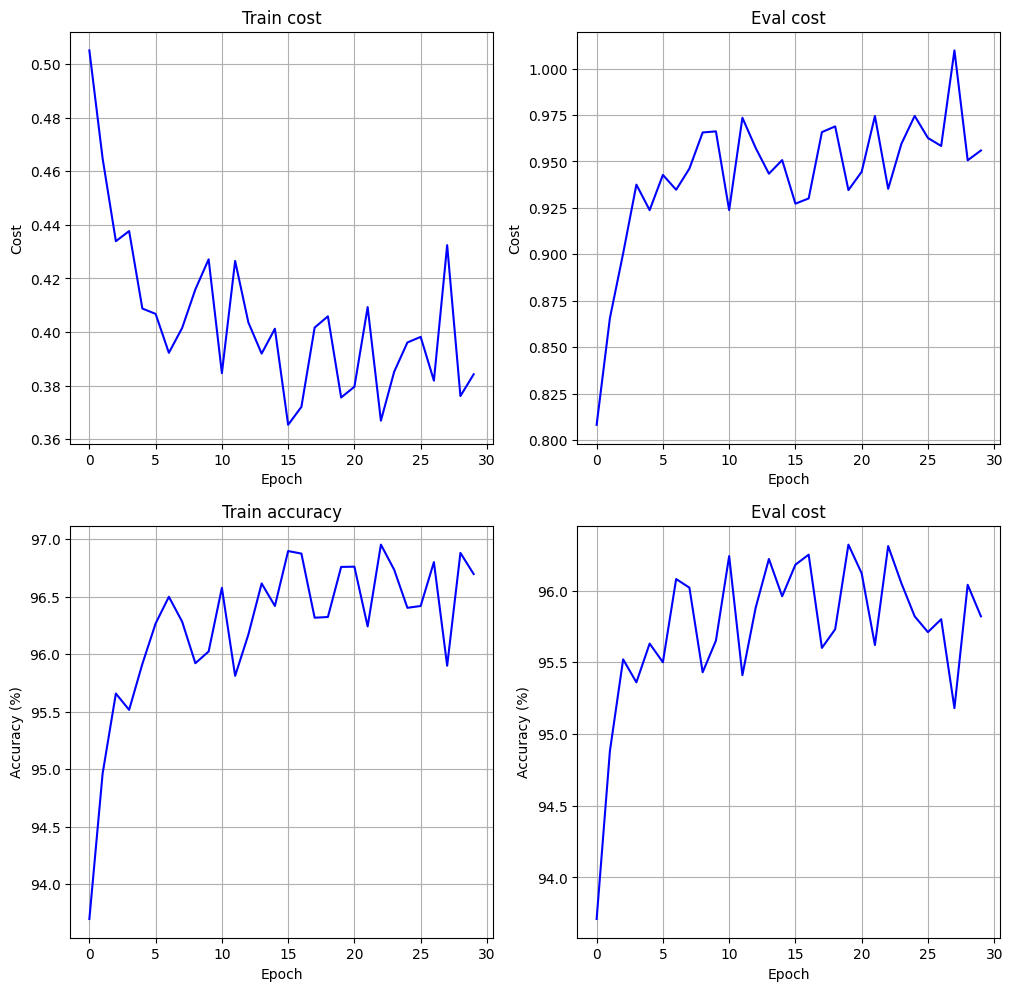

In [25]:
import matplotlib.pyplot as plt

%matplotlib inline

# Plot figures
xs = np.arange(30)

fig = plt.figure(figsize=(12, 12), dpi=100)
plt.subplot(2, 2, 1)
plt.title("Train cost")
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.plot(xs, train_cost, "b")

plt.subplot(2, 2, 2)
plt.title("Eval cost")
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.plot(xs, eval_cost, "b")

plt.subplot(2, 2, 3)
plt.title("Train accuracy")
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.plot(xs, np.array(train_accu)/500, "b")

plt.subplot(2, 2, 4)
plt.title("Eval accuracy")
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.plot(xs, np.array(eval_accu)/100, "b")

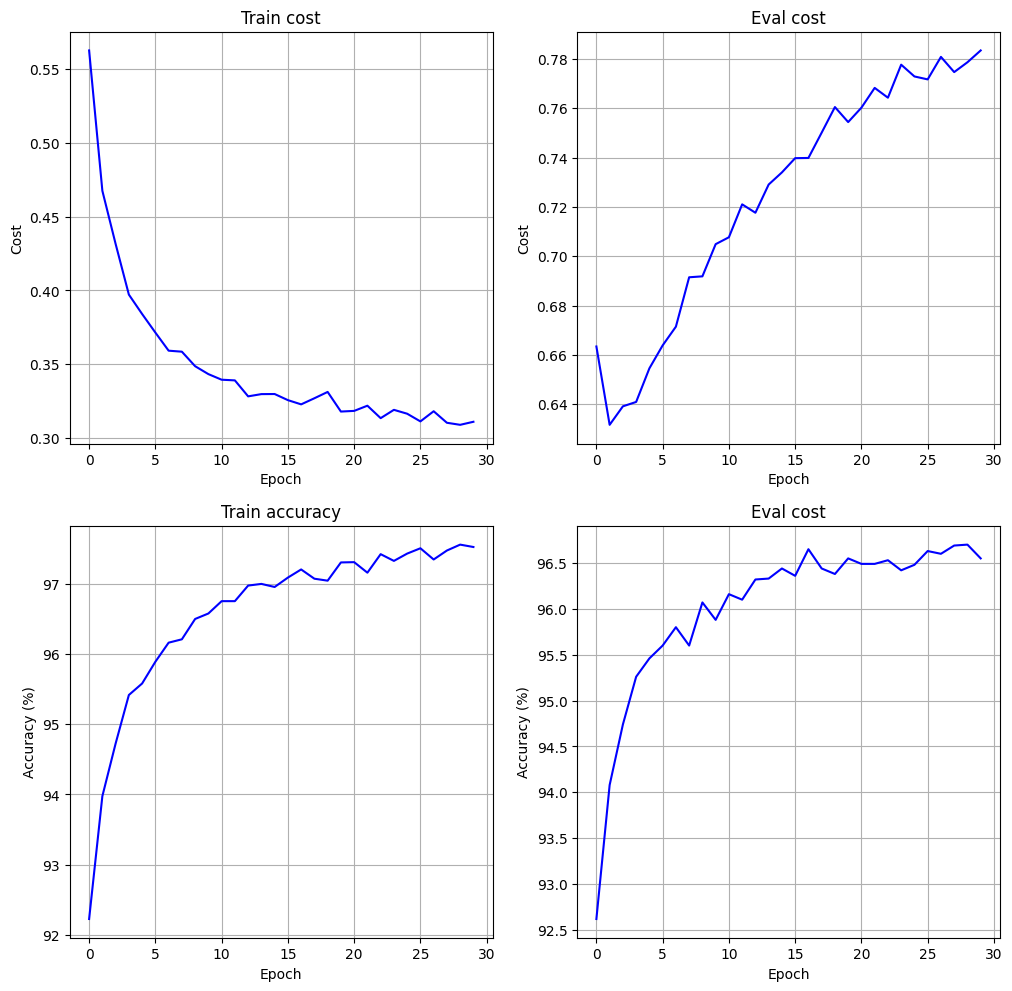

In [27]:
import matplotlib.pyplot as plt

%matplotlib inline

# Plot figures
xs = np.arange(30)

fig = plt.figure(figsize=(12, 12), dpi=100)
plt.subplot(2, 2, 1)
plt.title("Train cost")
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.plot(xs, train_cost, "b")

plt.subplot(2, 2, 2)
plt.title("Eval cost")
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.plot(xs, eval_cost, "b")

plt.subplot(2, 2, 3)
plt.title("Train accuracy")
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.plot(xs, np.array(train_accu)/500, "b")

plt.subplot(2, 2, 4)
plt.title("Eval accuracy")
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.plot(xs, np.array(eval_accu)/100, "b")